# What are the original feature maps of the `torchvision` model?

In [14]:
import torchvision

model = torchvision.models.vit_b_32(pretrained=True)

In [45]:
filters, biases = model.conv_proj.weight, model.conv_proj.bias

# Normalize the filters
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

In [66]:
# Count the number of filters that are "dead", i.e., grayish
dead_filters = 0
dead_filters_idx = []
for idx, f in enumerate(filters):
    if f.std() < 0.01:
        dead_filters += 1
        dead_filters_idx.append(idx)

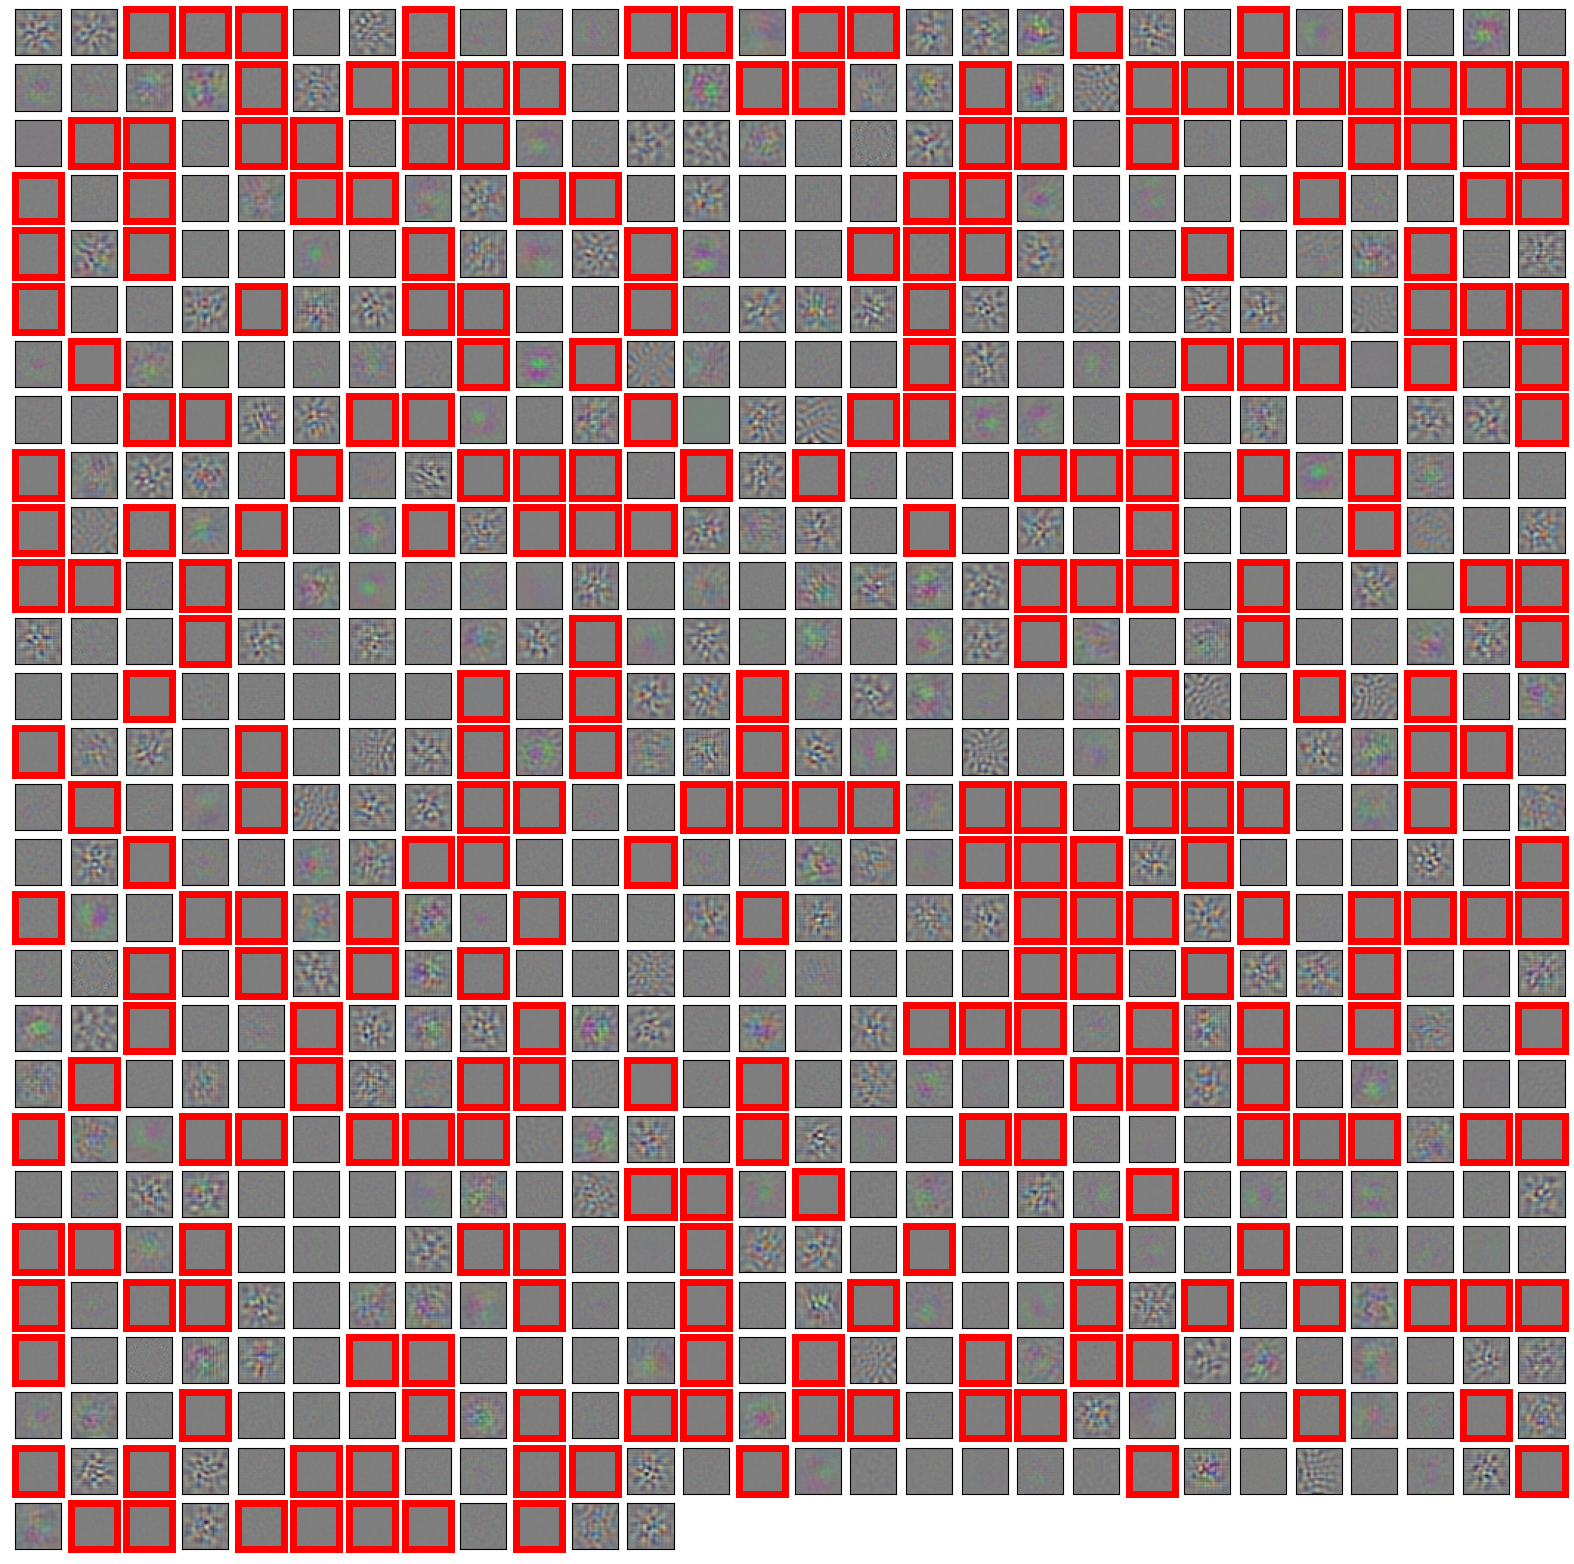

In [73]:
import numpy as np
import matplotlib.pyplot as plt

n_filters = filters.shape[0]

n_rows = int(np.rint(np.sqrt(n_filters)))
n_cols = int(np.ceil(n_filters / n_rows))

plt.figure(figsize=(20, 20))

for i in range(n_filters):
    # Plot the filters; if the filter is dead (according to dead_filters_idx), then
    # add a red border around it
    plt.subplot(n_rows, n_cols, i + 1)
    plt.imshow(filters[i].detach().numpy().transpose(1, 2, 0))
    if i in dead_filters_idx:
        plt.gca().spines['top'].set_color('red')
        plt.gca().spines['bottom'].set_color('red')
        plt.gca().spines['left'].set_color('red')
        plt.gca().spines['right'].set_color('red')
        # Increase line width
        plt.gca().spines['top'].set_linewidth(5)
        plt.gca().spines['bottom'].set_linewidth(5)
        plt.gca().spines['left'].set_linewidth(5)
        plt.gca().spines['right'].set_linewidth(5)
    plt.xticks([])
    plt.yticks([])

plt.show()

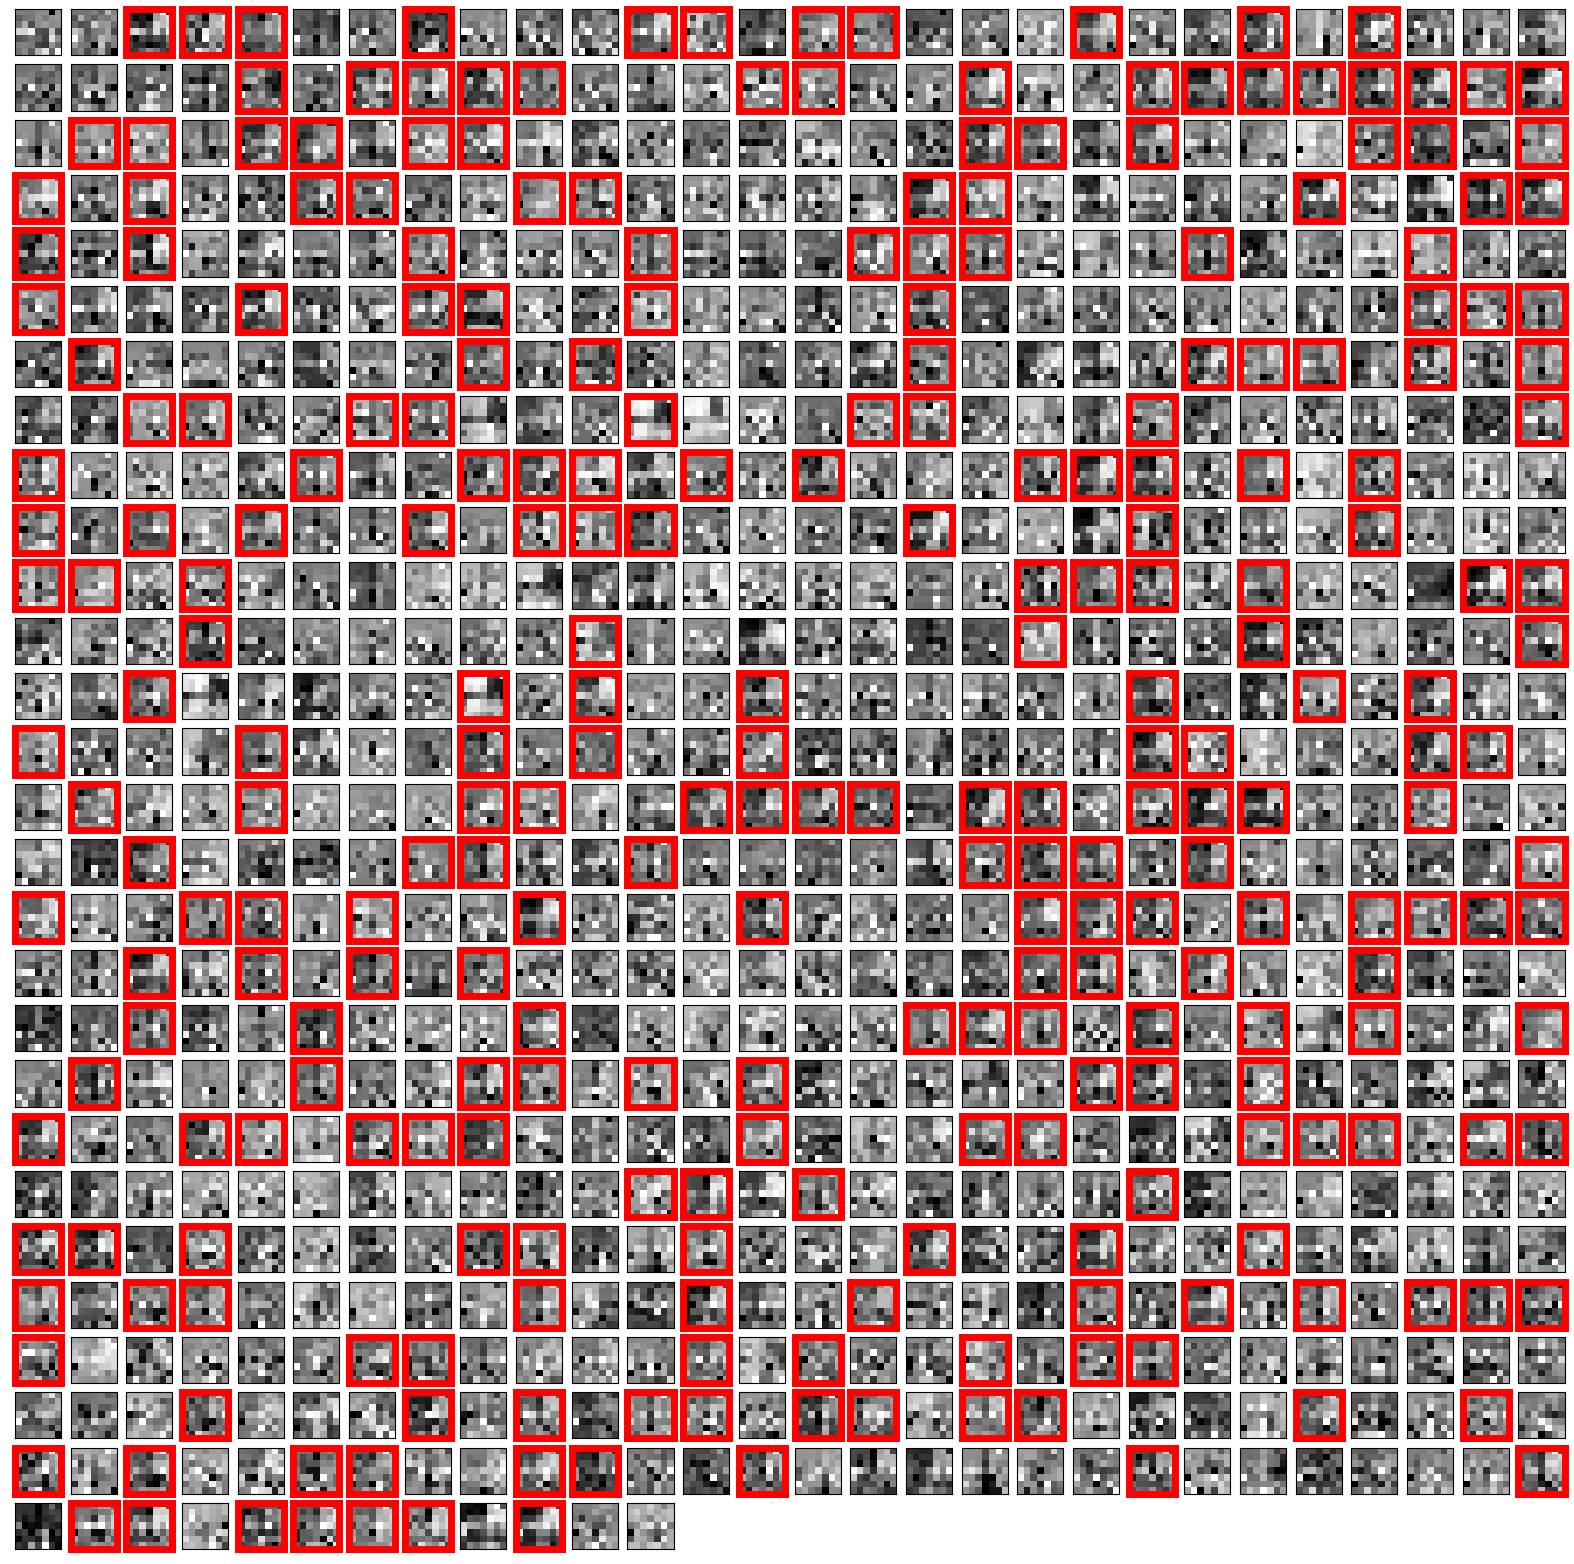

In [82]:
# Now, what do we get once we pass an image to it?

import torch
import torchvision.transforms as T
from PIL import Image

# Load an image
source_img = Image.open('test_data/dense_roach_route00/rgb_central000785.png')

# Normalize it w.r.t.. ImageNet statistics
normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
resize = T.Resize(224)
to_tensor = T.ToTensor()

img = normalize(to_tensor(resize(source_img))).unsqueeze(0)

# Pass it through the model
out = model.conv_proj(img)

# Plot the output
nrows = int(np.rint(np.sqrt(out.shape[1])))
ncols = int(np.ceil(out.shape[1] / nrows))

plt.figure(figsize=(20, 20))

for i in range(out.shape[1]):
    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(out[0, i].detach().numpy(), cmap='gray')
    if i in dead_filters_idx:
        plt.gca().spines['top'].set_color('red')
        plt.gca().spines['bottom'].set_color('red')
        plt.gca().spines['left'].set_color('red')
        plt.gca().spines['right'].set_color('red')
        # Increase line width
        plt.gca().spines['top'].set_linewidth(5)
        plt.gca().spines['bottom'].set_linewidth(5)
        plt.gca().spines['left'].set_linewidth(5)
        plt.gca().spines['right'].set_linewidth(5)
    plt.xticks([])
    plt.yticks([])

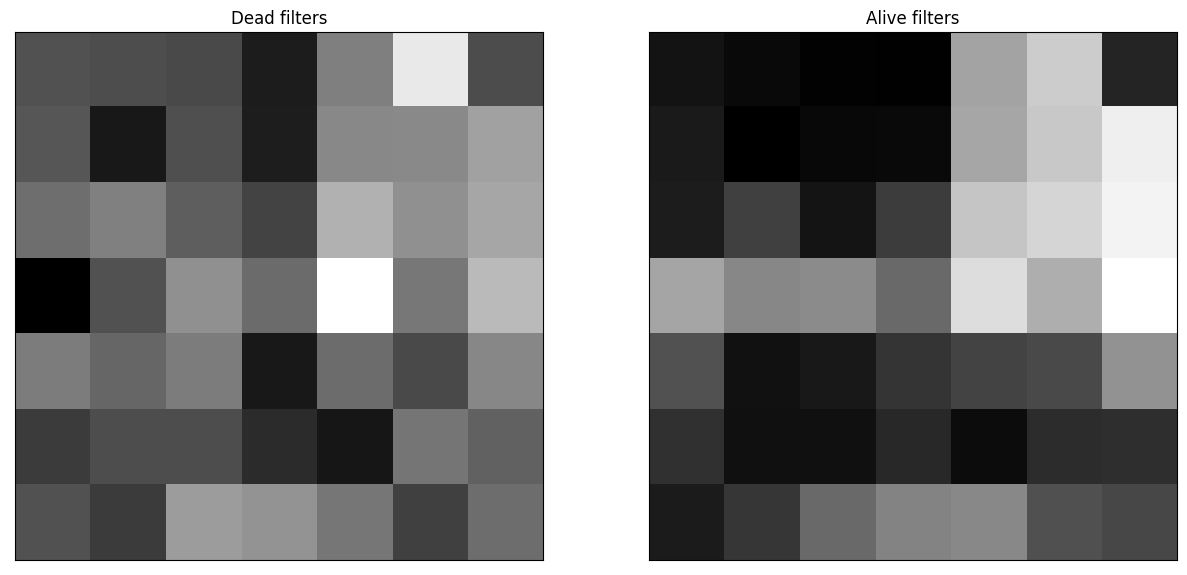

In [83]:
# Average the filters that are dead and those that aren't dead
dead_filters = out[0, dead_filters_idx].mean(dim=0)
alive_filters = out[0, [i for i in range(out.shape[1]) if i not in dead_filters_idx]].mean(dim=0)

# Plot the average filters
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.imshow(dead_filters.detach().numpy(), cmap='gray')
plt.title('Dead filters')
plt.xticks([])
plt.yticks([])
plt.subplot(1, 2, 2)
plt.imshow(alive_filters.detach().numpy(), cmap='gray')
plt.title('Alive filters')
plt.xticks([])
plt.yticks([])
plt.show()


## Now, after training, what did the one sequence model learn?

In [20]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from network.models.architectures.CIL_multiview.CIL_multiview import CIL_multiview
import os
from configs import g_conf, set_type_of_process, merge_with_yaml

exp_batch = 'CIL_ViT_oneseq'
exp_name = 'CILv2_3cam_vitb32_Town01Full_oneseq_bs256_fPE_wmupcdown_lr1e4_preACT_noCLS_out2MLPbig_hres'

In [21]:
merge_with_yaml(os.path.join('configs', exp_batch, f'{exp_name}.yaml'))
g_conf.PROCESS_NAME = 'train_val'
g_conf.DATASET_PATH = '/datatmp/Datasets/yixiao/CARLA'

os.environ['DATASET_PATH'] = g_conf.DATASET_PATH

cil_model = CIL_multiview(g_conf.MODEL_CONFIGURATION)

In [29]:
from _utils.training_utils import check_saved_checkpoints

latest_checkpoint = check_saved_checkpoints(os.path.join('../VisionTFM',
                                                         '_results',
                                                         g_conf.EXPERIMENT_BATCH_NAME,
                                                         g_conf.EXPERIMENT_NAME,
                                                         'checkpoints'))

In [33]:
cil_model

CIL_multiview(
  (encoder_embedding_perception): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (linear_1): Linear(in_features=768, out_features=3072, bias=True)
            (act): GELU()
            (dropout_1): Dropout(p=0.0, inplace=False)
            (linear_2): Linear(in_features=3072, out_features=768, bias=True)
            (dropout_2): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_

In [ ]:
filters, biases = model.conv_proj.weight, model.conv_proj.bias

# Normalize the filters
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

n_filters = filters.shape[0]

n_rows = int(np.rint(np.sqrt(n_filters)))
n_cols = int(np.ceil(n_filters / n_rows))

plt.figure(figsize=(20, 20))

for i in range(n_filters):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.imshow(filters[i].detach().numpy().transpose(1, 2, 0))
    plt.axis('off')

plt.show()

In [37]:
import torch

checkpoint = torch.load(latest_checkpoint)

checkpoint['model'].keys()

odict_keys(['_model.tfx_accel_token', '_model.tfx_steer_token', '_model.encoder_embedding_perception.class_token', '_model.encoder_embedding_perception.conv_proj.weight', '_model.encoder_embedding_perception.conv_proj.bias', '_model.encoder_embedding_perception.encoder.layers.encoder_layer_0.ln_1.weight', '_model.encoder_embedding_perception.encoder.layers.encoder_layer_0.ln_1.bias', '_model.encoder_embedding_perception.encoder.layers.encoder_layer_0.self_attention.in_proj_weight', '_model.encoder_embedding_perception.encoder.layers.encoder_layer_0.self_attention.in_proj_bias', '_model.encoder_embedding_perception.encoder.layers.encoder_layer_0.self_attention.out_proj.weight', '_model.encoder_embedding_perception.encoder.layers.encoder_layer_0.self_attention.out_proj.bias', '_model.encoder_embedding_perception.encoder.layers.encoder_layer_0.ln_2.weight', '_model.encoder_embedding_perception.encoder.layers.encoder_layer_0.ln_2.bias', '_model.encoder_embedding_perception.encoder.layers.e

In [39]:
checkpoint['model']['_model.encoder_embedding_perception.conv_proj.weight'].shape

torch.Size([768, 3, 32, 32])

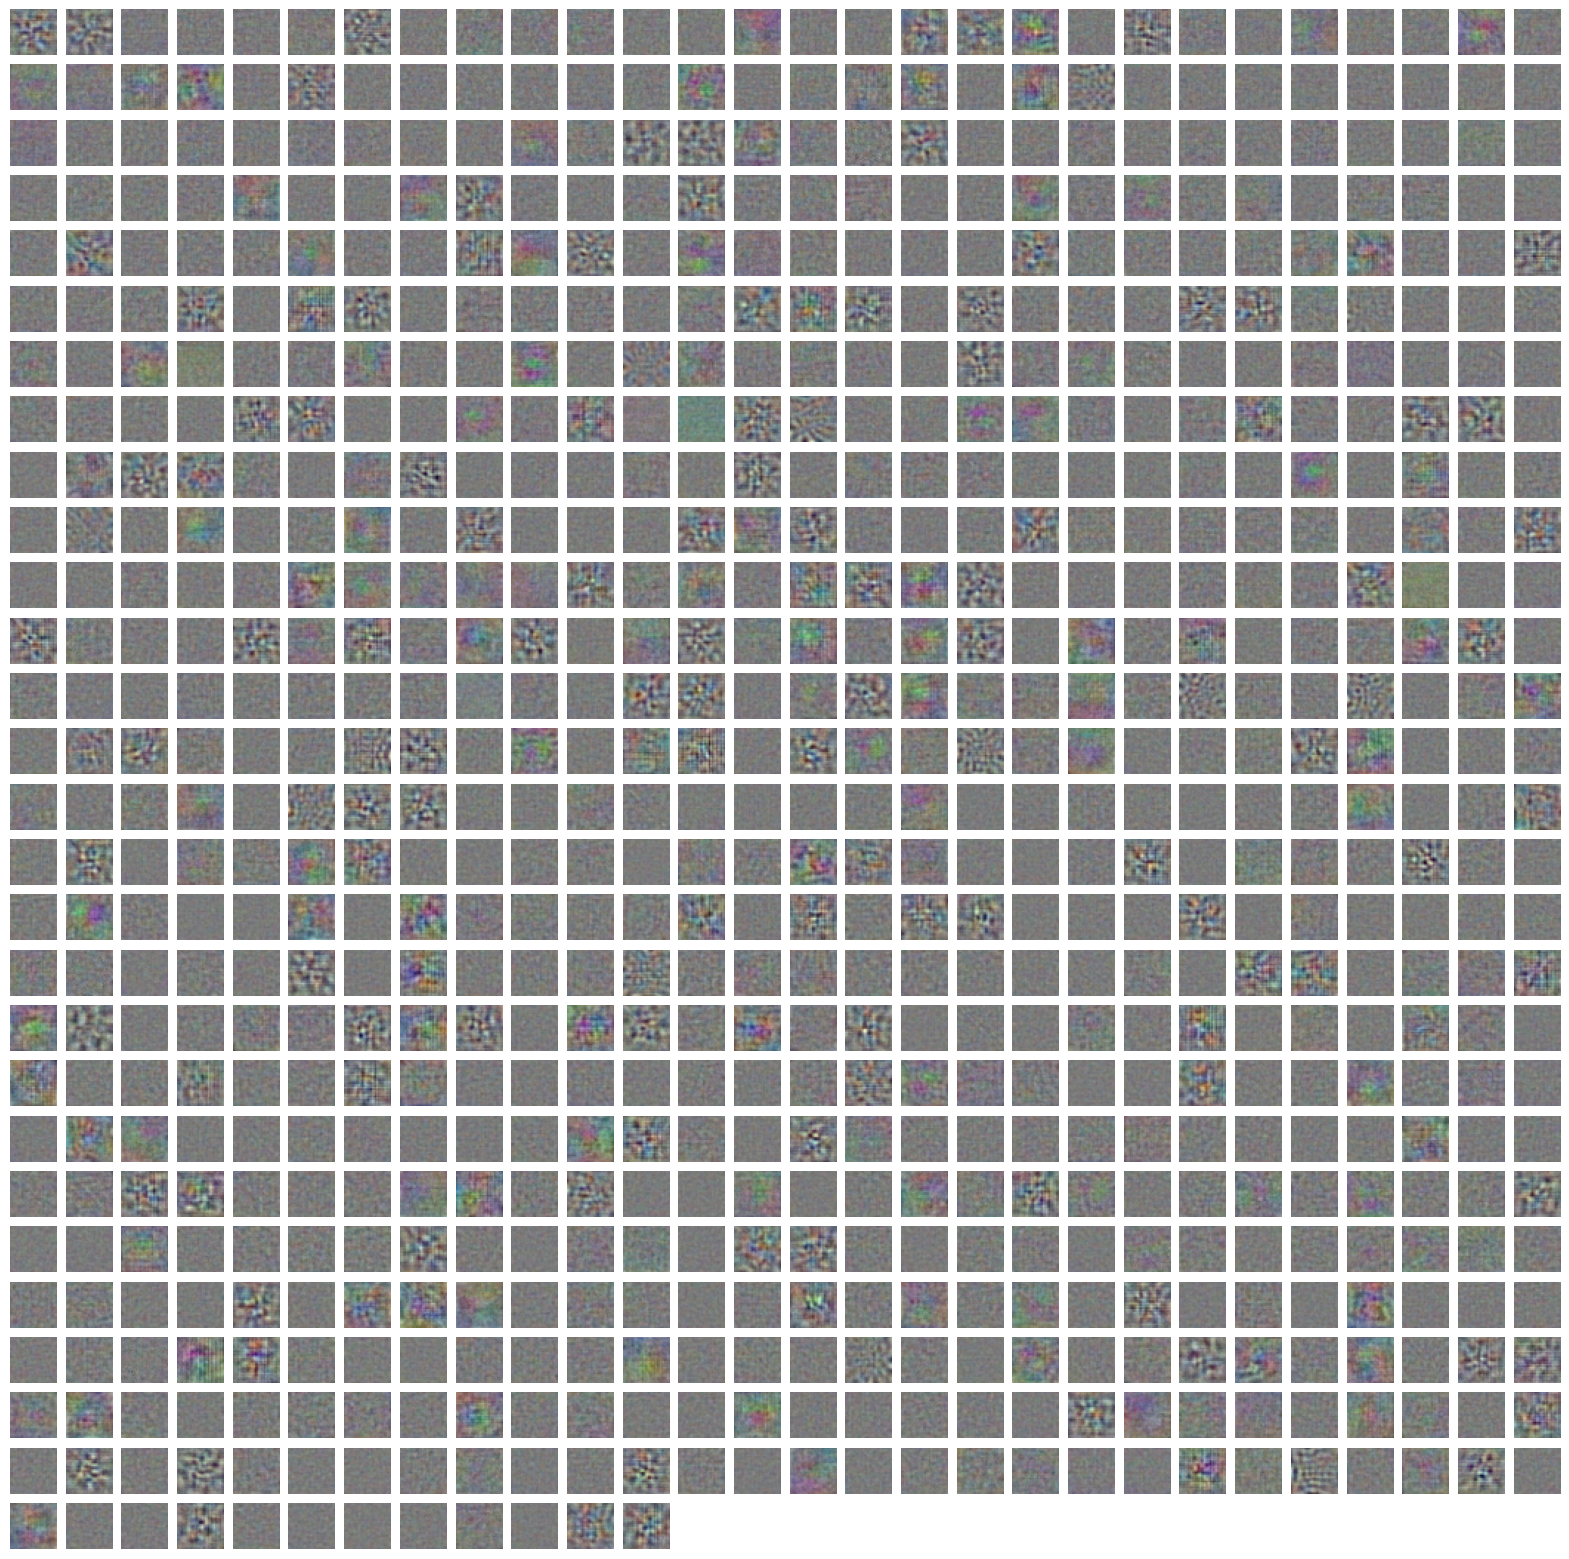

In [84]:
filters = checkpoint['model']['_model.encoder_embedding_perception.conv_proj.weight'].cpu()
# Normalize the filters
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

n_filters = filters.shape[0]

# Count the number of filters that are "dead", i.e., grayish
dead_filters_cil = 0
dead_filters_cil_idx = []
for idx, f in enumerate(filters):
    if f.std() < 0.01:
        dead_filters_cil += 1
        dead_filters_cil_idx.append(idx)

n_rows = int(np.rint(np.sqrt(n_filters)))
n_cols = int(np.ceil(n_filters / n_rows))

plt.figure(figsize=(20, 20))

for i in range(n_filters):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.imshow(filters[i].detach().numpy().transpose(1, 2, 0))
    if i in dead_filters_cil_idx:
        plt.gca().spines['top'].set_color('red')
        plt.gca().spines['bottom'].set_color('red')
        plt.gca().spines['left'].set_color('red')
        plt.gca().spines['right'].set_color('red')
        # Increase line width
        plt.gca().spines['top'].set_linewidth(5)
        plt.gca().spines['bottom'].set_linewidth(5)
        plt.gca().spines['left'].set_linewidth(5)
        plt.gca().spines['right'].set_linewidth(5)
    plt.axis('off')

plt.show()